# Leaf Image Classification


There are estimated to be nearly half a million species of plant in the world. Classification of species has been historically problematic and often results in duplicate identifications. Automating plant recognition might have many applications, including:

1. Species population tracking and preservation
2. Plant-based medicinal research
3. Crop and food supply management

The objective of this playground competition is to use binary leaf images and extracted features, including shape, margin & texture, to accurately identify 99 species of plants. Leaves, due to their volume, prevalence, and unique characteristics, are an effective means of differentiating plant species. They also provide a fun introduction to applying techniques that involve image-based features.

As a first step, try building a classifier that uses the provided pre-extracted features. Next, try creating a set of your own features. Finally, examine the errors you're making and see what you can do to improve.

We will be following along this kernel: https://www.kaggle.com/alutrin/leaf-classification/simple-cnn-leaves-with-features-plugged-in-later

In [1]:
from __future__ import print_function
%matplotlib inline
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image

from PIL import Image
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Let's start with some simple globals
dim = 20
batch_size = 128

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [3]:
images = np.empty((len(train['id']), dim, dim, 1))
print(images.shape)

i = 0
for id in train['id']:
    filename = "images/"+str(id)+".jpg"
    im = Image.open(filename)
    im.thumbnail([dim, dim])
    im = np.array(im)
    height, width = im.shape
    
    #calculate destination coordinates
    h1 = int((dim - height) / 2)
    h2 = h1 + height
    w1 = int((dim - width) / 2)
    w2 = w1 + width
    
    images[i, h1:h2, w1:w2, 0] = im
    i += 1
    
print(images.shape)

(990, 20, 20, 1)
(990, 20, 20, 1)


In [4]:
y_all = train.pop('species')
y_all = LabelEncoder().fit(y_all).transform(y_all)
y_all = to_categorical(y_all)
print(y_all.shape)
train.pop('id')
featuresAll = StandardScaler().fit(train).transform(train)

(990, 99)


In [5]:
featuresAll.shape

(990, 192)

# Defining a Convolutional Neural Network

In [6]:
#start with a simple FC layer

image_mean = images.mean().astype(np.float32)
image_std = images.std().astype(np.float32)

def normalize(x): 
    return (x-image_mean)/image_std

model = Sequential([
    Lambda(normalize, input_shape=(dim,dim,1)),
        Conv2D(16,(3,3), activation='relu'),
        Conv2D(16, (3,3), activation='relu'),
        MaxPooling2D(),
        Conv2D(32,(3,3), activation='relu'),
        ZeroPadding2D((1, 1)),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(20, activation='relu'),
        Dense(y_all.shape[1], activation='softmax')
    ])
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

## Components of the CNN

### Convolutions

In [67]:
from IPython.display import Image
Image(url='convolution_schematic.gif')  

Source: http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution

### Max Pooling 

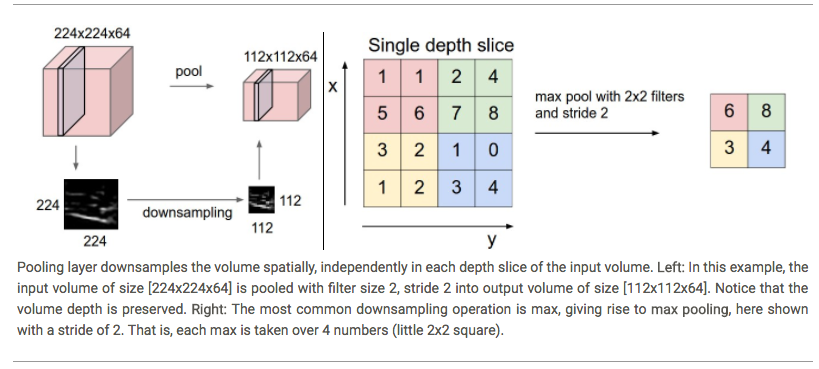

In [66]:
from IPython.display import Image
Image("max_pooling.png")

Source: http://cs231n.github.io/convolutional-networks/#conv

## Creating Training, Validation, and Test Sets

In [8]:
#split test and validation
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=0)
train_index, val_index = next(sss.split(images, y_all))
x_train, y_train = images[train_index], y_all[train_index]
features_train = featuresAll[train_index]
x_val, y_val = images[val_index], y_all[val_index]
features_val = featuresAll[val_index]

### Make Sure the Data is in Ship Shape

In [8]:
print("Training image set shape: {}".format(x_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation image set shape: {}".format(x_val.shape))
print("Training label shape: {}".format(y_val.shape))
print("Training feature set shape: {}".format(features_train.shape))
print("Validation feature set shape: {}".format(features_val.shape))

Training image set shape: (693, 20, 20, 1)
Training label shape: (693, 99)
Validation image set shape: (99, 20, 20, 1)
Training label shape: (99, 99)
Training feature set shape: (693, 192)
Validation feature set shape: (99, 192)


In [86]:
generator = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, 
                                     height_shift_range=0.08, zoom_range=0.08)

train_batches = generator.flow(x_train, y_train, batch_size=batch_size)
val_batches = generator.flow(x_val, y_val, batch_size=batch_size)

In [ ]:
model.fit_generator(train_batches, train_batches.n, nb_epoch=1, 
                    validation_data=val_batches, nb_val_samples=val_batches.n)

Epoch 1/5
  1/693 [..............................] - ETA: 113s - loss: 1.8981 - acc: 0.4062

/Users/youngtodd/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., 693, epochs=5, validation_data=<keras.pre..., validation_steps=99)`
  from ipykernel import kernelapp as app


585/693 [========================>.....] - ETA: 11s - loss: 1.6258 - acc: 0.4853 